**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper. The target variable would be a binary variable (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%.

### **Task 1. Imports and data loading**

We will build a random forest and XGBoost model

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score,\
precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,\
RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from xgboost import plot_importance

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)

In [3]:
df0=pd.read_csv('/content/drive/My Drive//01_Projects/01_NYC_taxi/Taxi_Data.csv')

# Import predicted fares and mean distance and duration
nyc_preds_means = pd.read_csv('/content/drive/My Drive/data/nyc_preds_means.csv')


In [4]:
# Inspect the first rows of df0
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [5]:
# Inspect the first few rows of `nyc_preds_means`
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


In [6]:
# Merge datasets
df0 = df0.merge(nyc_preds_means, left_index=True, right_index=True)
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


### **Task 2. Feature engineering**

In [7]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In the previous notes, the EDA revealed that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, you'll need to sample the data to select only the customers who pay with credit card.

In [8]:
# Subset the data to isolate only customers who paid by credit card
df1 = df0[df0['payment_type']==1]

##### **Target**

Notice that there isn't a column that indicates tip percent, which is what you need to create the target variable. You'll have to engineer it.

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

Round the result to three places beyond the decimal. **This is an important step.** It affects how many customers are labeled as generous tippers. In fact, without performing this step, approximately 1,800 people who do tip ≥ 20% would be labeled as not generous.

In [9]:
# Create tip % col
df1 = df1.copy()
df1['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)

Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [10]:
df1['generous'] = df1['tip_percent'] >= 0.2
df1['generous'] = df1['generous'].astype(int) # to convert the boolean to int
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1


Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [11]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [12]:
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [13]:
# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

You'll need to write four functions to convert each new column to binary (0/1).

In [14]:
def am_rush(hour):
  if 6 <= hour['am_rush'] < 10:
    val = 1
  else:
    val = 0
  return val

def daytime(hour):
  if 10 <= hour['daytime'] < 16:
    val = 1
  else:
    val = 0
  return val

def pm_rush(hour):
  if 16 <= hour['pm_rush'] < 20:
    val = 1
  else:
    val = 0
  return val


def nighttime(hour):
  if 20 <= hour['nighttime'] < 24:
    val = 1
  else:
    val = 0
  return val

In [15]:
# apply the functions
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['daytime'] = df1.apply(daytime, axis=1)
df1['pm_rush'] = df1.apply(pm_rush, axis=1)
df1['nighttime'] = df1.apply(nighttime, axis=1)
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,0.200,1,saturday,1,0,0,0
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,0.238,1,tuesday,0,1,0,0
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,0.199,0,friday,1,0,0,0
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,0.300,1,sunday,0,1,0,0
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,0.200,1,saturday,0,0,0,1


Create a month column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [16]:
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (generous) must remain in the data because it will get isolated as the y data for modeling.

In [17]:
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`.

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.


In [18]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

In [19]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: float64(3), int64(6), uint8(338)
memory usage: 6.1 MB


##### Evaluation metric

Before modeling, you must decide on an evaluation metric.

1. Examine the class balance of your target variable.

In [20]:
df2['generous'].value_counts(normalize=True)

1    0.526368
0    0.473632
Name: generous, dtype: float64

A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**The stakes are relatively even. You want to help taxi drivers make more money, but you don't want this to anger customers. Our metric should weigh both precision and recall equally.**

F<sub>1</sub> score is the metric that places equal weight on true postives and false positives, and so therefore on precision and recall.

### **Task 3. Modeling**

##### **Split the data**

Now qw're ready to model. The only remaining step is to split the data into features/target variable and training/testing data.

1. Define a variable `y` that isolates the target variable (`generous`).
2. Define a variable `X` that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [21]:
# Isolate the target variable (y)
y = df2['generous']

# Isolate the feartures (X)
X = df2.drop('generous', axis=1)

# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

##### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.
 - `max_depth`  
 - `max_features`  
 - `max_samples`
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a set `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)

 **Note:** `refit` should be set to `'f1'`.


In [22]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {
    'max_depth': [None],
    'max_features': [1.0],
    'max_samples': [0.7],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [300]
}

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

In [23]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 5min 23s, sys: 487 ms, total: 5min 23s
Wall time: 5min 26s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring={'f1', 'recall', 'accuracy', 'precision'})

In [24]:
# Examine the best score
rf1.best_score_

0.7151906407391807

In [25]:
# Examine the best combination of hyperparameters
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [26]:
# Custom function to output the results nicely
def make_results(model_name:str, model_object, metric:str):
  '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''
    # Create a dictionary that maps input metric to actual metric name in GridSearchCV
  metric_dict = {
        'precision':'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }
  # Get all the results from the CV and put them in df
  cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df with the max metric score
  best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(),:]

  # Extract Accuracy, precision, recall, and f1 score from that row
  f1 = best_estimator_results.mean_test_f1
  recall = best_estimator_results.mean_test_recall
  precision = best_estimator_results.mean_test_precision
  accuracy = best_estimator_results.mean_test_accuracy

  # Create table of results
  table = pd.DataFrame({'model': [model_name],
                      'precision': [precision],
                      'recall': [recall],
                      'F1': [f1],
                      'accuracy': [accuracy],
                      },
                      )

  return table


In [27]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.676689,0.758712,0.715191,0.682198


This is an acceptable model across the board. Typically scores of 0.65 or better are considered acceptable, but this is always dependent on your use case. Optional: try to improve the scores. It's worth trying, especially to practice searching over different hyperparameters.


In [28]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

In [29]:
# Let's write a function that will output the test results nicely

def get_test_scores(model_name:str, preds, y_test_data):
  '''
  Generate a table of test scores.

  In:
  model_name (string): Your choice: how the model will be named in the output table
  preds: numpy array of test predictions
  y_test_data: numpy array of y_test data

  Out:
  table: a pandas df of precision, recall, f1, and accuracy scores for your model
  '''
  accuracy = accuracy_score(y_test_data, preds)
  precision = precision_score(y_test_data, preds)
  recall = recall_score(y_test_data, preds)
  f1 = f1_score(y_test_data, preds)

  table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

  return table

###### RF test results

In [30]:
rf_test_scores = get_test_scores('RF_test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.676689,0.758712,0.715191,0.682198
0,RF_test,0.673713,0.773491,0.720162,0.683590


##### **XGBoost**

 Try to improve your scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a set `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [31]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the `X_train` and `y_train` data.

In [32]:
%%time
xgb1.fit(X_train, y_train)

CPU times: user 47.6 s, sys: 251 ms, total: 47.9 s
Wall time: 30.5 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring={'f1', 'recall', 'accuracy', 'precision'})

In [33]:
# Examine best score
xgb1.best_score_

0.6939091822450458

In [34]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

###### XGB CV results

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments.

In [35]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.676689,0.758712,0.715191,0.682198
0,RF_test,0.673713,0.773491,0.720162,0.683590
0,XGB CV,0.669563,0.720286,0.693909,0.665575


In [36]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

In [37]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.676689,0.758712,0.715191,0.682198
0,RF_test,0.673713,0.773491,0.720162,0.683590
0,XGB CV,0.669563,0.720286,0.693909,0.665575
0,XGB test,0.676984,0.748600,0.710993,0.679659


**Results:** The F<sub>1</sub> score is ~0.01 lower than the random forest model. Both models are acceptable, but the random forest model is the champion.

Plot a confusion matrix of the champion model's predictions on the test data.

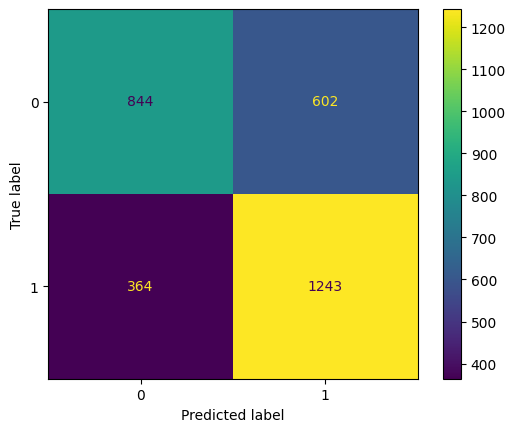

In [38]:
# Generate array of values for the confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf1.classes_)

#plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf1.classes_)
disp.plot(values_format='')

**Note:** The model is almost twice as likely to predict a false positive than it is to predict a false negative. Therefore, type I errors are more common. This is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory.

##### Feature importance

Use the `feature_importances_` attribute of the best estimator object to inspect the features of your final model. You can then sort them and plot the most important ones.

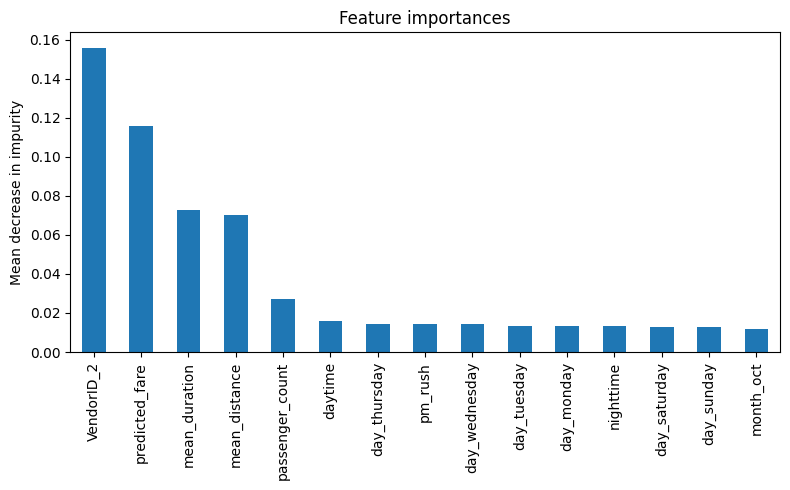

In [39]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();